In [30]:
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import interpolate as interp
import floatpy.readers.padeops_reader as por
import scripts.statistics as stats
import scripts.get_namelist as nml
%matplotlib inline
%config InlineBackend.figure_format = 'png'

fs = 12

def plot_TKEBudget(reader, savename=''):
    #namelist = ('rho_bar', 'tke', 'TKE_rate','dissipation', 'dissipation_num', \
    #            'p_dil_fluct', 'fluct_p_dil', 'production','baropycnal', 'u_tilde', 'u_pprime_bar')

    namelist = ('TKE_rate','dissipation', 'dissipation_num','diss_mass_flux', \
                'p_dil_fluct', 'fluct_p_dil', 'production','baropycnal')
    ddt_tke, dissipation, num_dissipation, diss_mass_flux, \
    p_dil, f_p_dil, production, baropycnal = reader.readData(namelist)

    variables = {r'$\partial \bar{\rho} \tilde{k} / \partial t$': ddt_tke,\
                 r'Dissipation': dissipation,\
                 r'Numerical dissipation': num_dissipation,\
                 r'Mass flux': diss_mass_flux,\
                 r'Pressure dilatation': p_dil,\
                 r'Fluctuation pressure dilatation': f_p_dil,\
                 r'Production': production,\
                 r'Baropycnal': baropycnal}
    
    plt.figure(figsize=(8,4), dpi=100)
    for i, var in enumerate(variables):
        im = plt.plot(y[0,:,0],variables[var][0, :, 0],label=var)
    plt.xlabel(r'$y$', fontsize=fs)        
    plt.tick_params(labelsize=fs)
    plt.tight_layout()
    plt.legend(namelist)
    
    if savename:
        plt.savefig(savename, dpi=500)
        plt.close(fig)
        print "Saved plot to " + savename
def growth_rates(filename_prefix):
    fname = filename_prefix+'growth.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)

    nstats=3
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    dtheta = dat[:,1]
    domega = dat[:,2]
    return time,dtheta,domega 

def plot_one(dirname, reader, qname, steps):
    
    time,dtheta,domega = growth_rates(dirname+'/shearlayer_')
    
    plt.figure(figsize=(8,4), dpi=100)
    
    ymax = 10
    qplot_mean = 0.
    yplot_mean = np.linspace(-ymax,ymax,Ny/2)
    
    for step in steps:
        reader.step = step
        t = reader.time
        q = reader.readData(qname)
        d = dtheta[np.argmin(abs(time-t))]
        qplot = np.squeeze(np.array(q))*inp.du**3
        if (qname!='rho_bar'): qplot /= d
        yplot = y[0,:,0]/d
        plt.plot(yplot,qplot,label="t = {}".format(t),alpha=0.4)
        
        # interp onto the mean grid for plotting
        qplot_mean += np.interp(yplot_mean, yplot, qplot)
        
    plt.plot(yplot_mean,qplot_mean/np.size(steps),'k-',label='Mean')
    plt.xlabel(r'$\eta$', fontsize=fs)        
    plt.tick_params(labelsize=fs)
    plt.grid(True)
    plt.tight_layout()
    plt.xlim([-ymax,ymax])
    plt.legend(bbox_to_anchor=(1.5, 0.3))

def plot_all(dirname, reader, steps):
    
    qnames = ('TKE_rate','production','p_dil_fluct', 'fluct_p_dil','baropycnal',\
              'diss_fluct','diss_mass_flux','dissipation_num')
    qnames_nice = (r'TKE rate: $\dot{k}$', 
                   r'Production: -$\overline{\rho} \tilde{R}_{ij} \tilde{u}_{i,j}$ ',
                   r'Pressure fluctuation-dilatation: $\overline{pu^{\prime\prime}_{i,i}}$',
                   r'Fluctuating pressure fluctuation-dilatation correlation: $\overline{p^\prime u^{\prime\prime}_{i,i}}$',
                   r'Baropycnal: -$\overline{u^{\prime\prime}_ip^\prime_{,i}}$',
                   r'Dissipation: $\overline{\tau_{ij}u^{\prime\prime}_{i,j}}$',
                   r'Mass flux: $\overline{u^{\prime\prime}_{i}}\overline{\tau}_{ij,j}$',
                   'Dissipation (filter)'
                  )
    time,dtheta,domega = growth_rates(dirname+'/shearlayer_')
    
    nvars = len(qnames)
    ymax = Ny/4
    qplot_mean = np.zeros([8,Ny/2])
    yplot_mean = np.linspace(Ny/2-ymax,Ny/2+ymax,Ny/2)
    
    plt.figure(figsize=(8,4), dpi=100)
    for step in steps:
        reader.step = step
        t = reader.time
        q = reader.readData(qnames)
        d = dtheta[np.argmin(abs(time-t))]
        qplot = np.squeeze(np.array(q))# / d #* inp.du**2 << add this for scaling
        yplot = y[0,:,0]#/d
        for idx in range(0,nvars):
            qplot_mean[idx,:] += np.interp(yplot_mean, yplot, qplot[idx,:])
        
    qplot_mean = qplot_mean/(np.size(steps))
    for idx in range(0,nvars):        
        if 'diss' in qnames[idx]: 
            qplot_mean[idx,:] = -qplot_mean[idx,:]
        if 'TKE_rate' in qnames[idx]: 
            qplot_mean[idx,:] = -qplot_mean[idx,:]
        plt.plot(yplot_mean,qplot_mean[idx,:],label=qnames_nice[idx])    
    resid = np.squeeze(np.sum(qplot_mean,axis=0))
    plt.plot(yplot_mean,resid,'k-',label='Residual')
    
    plt.xlabel(r'$\eta$', fontsize=fs)        
    plt.tick_params(labelsize=fs)
    plt.grid(True)
    plt.tight_layout()
#     plt.xlim([-ymax,ymax])
    plt.legend(bbox_to_anchor=(0.7, 2))

In [42]:
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc07/724x1024x362/restart_debug'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/512x724x256/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1024x512'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1024x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/724x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1024x512/restart_0024'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc24/rr1/512x512x256/'


filename_prefix = directory + '/TKEBudget_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
x, y, z = reader.readCoordinates()
ymin, ymax = y[0,0,0], y[-1,-1,-1]
Ny = np.shape(y)[1]
inp = nml.inputs(directory,verbose=True)

steps = sorted(reader.steps)
print("Steps: {}".format(steps))

Params for this run:
	Mc = 0.8
	Re = 1000.0
	rr = 1.0
Steps: [0, 1, 2, 4, 5]


741.0
dtheta = 1


(-40, 40)

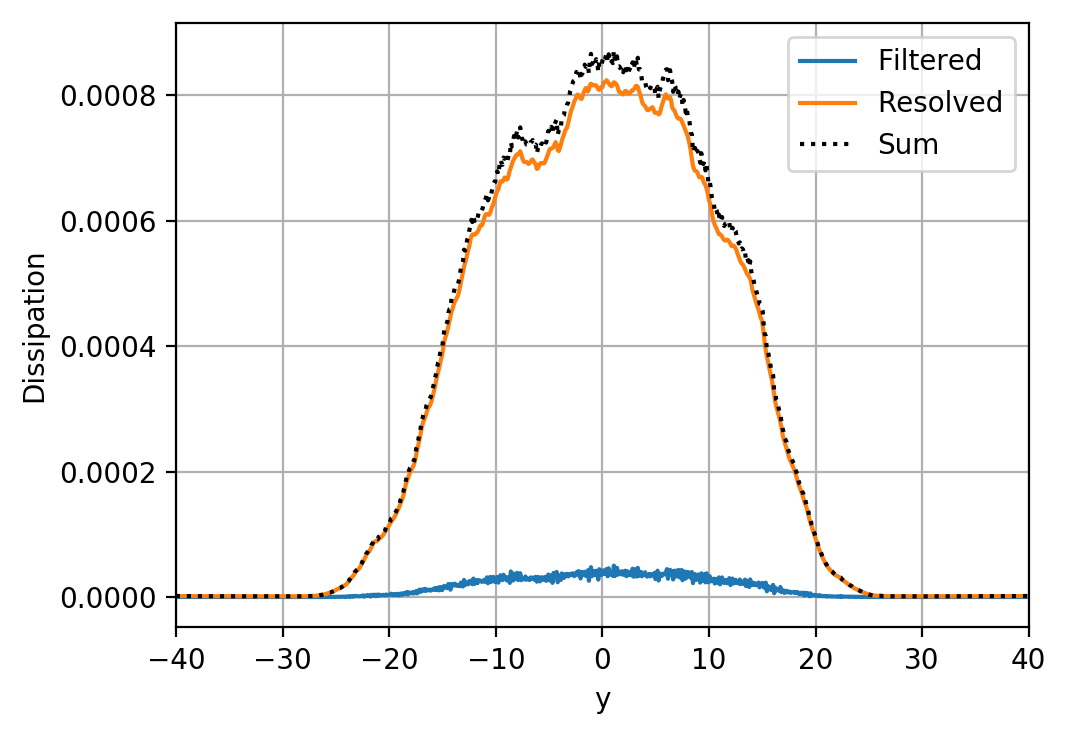

In [48]:
reader.step = 4
print(reader.time)

# time,dtheta,domega = growth_rates(directory+'/shearlayer_')
t = reader.time
d = 1#dtheta[np.argmin(abs(time-t))]
print("dtheta = {}".format(d))

diss_num = np.squeeze(reader.readData('dissipation_num'))
diss = np.squeeze(reader.readData('dissipation'))

yplot = y[0,:,0]
plt.figure(figsize=(5.5,4),dpi=200)
plt.plot(yplot,diss_num,label='Filtered')
plt.plot(yplot,diss,label='Resolved')
plt.plot(yplot,diss_num+diss,'k:',label='Sum')
plt.grid(True)
plt.legend()
plt.ylabel('Dissipation')
plt.xlabel('y')
# plt.title(r'$\epsilon_f/\epsilon_r$ = {:.3f}'.format(sum(diss_num)/sum(diss)) )
plt.xlim([-40,40])

268.0


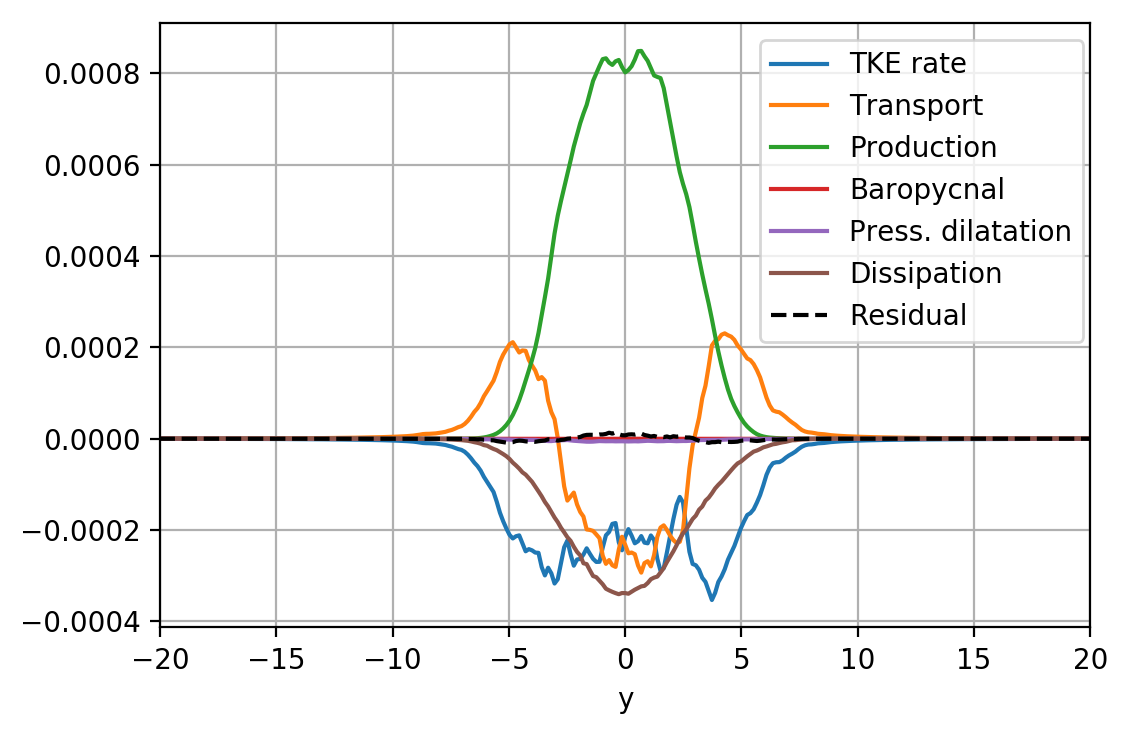

In [41]:
plt.figure(figsize=(6,4), dpi=200)
yplot = y[0,:,0]

reader.step = 5
dat = np.squeeze(reader.readData('TKE_rate')); plt.plot(yplot,-dat,label='TKE rate'); resid = -dat;
dat = np.squeeze(reader.readData('trans_conv'));  resid -= dat;
dat = np.squeeze(reader.readData('trans_turb')); plt.plot(yplot,dat,label='Transport'); resid += dat;
dat = np.squeeze(reader.readData('production')); plt.plot(yplot,dat,label='Production'); resid += dat;
dat = np.squeeze(reader.readData('baropycnal')); plt.plot(yplot,dat,label='Baropycnal'); resid += dat;
dat = np.squeeze(reader.readData('fluct_p_dil')); plt.plot(yplot,dat,label=r'Press. dilatation'); resid += dat;
dat = np.squeeze(reader.readData('dissipation')); diss=-dat; resid -= dat;
dat = np.squeeze(reader.readData('dissipation_num')); plt.plot(yplot,diss-dat,label='Dissipation'); resid -= dat;

plt.plot(yplot,resid,'k--',label='Residual')

print(reader.time)
plt.legend(bbox_to_anchor=(0.63,.45))
plt.xlim([-20,20])
plt.xlabel('y')
plt.grid(True)
# plt.savefig([directory+'/TKEB.png'])

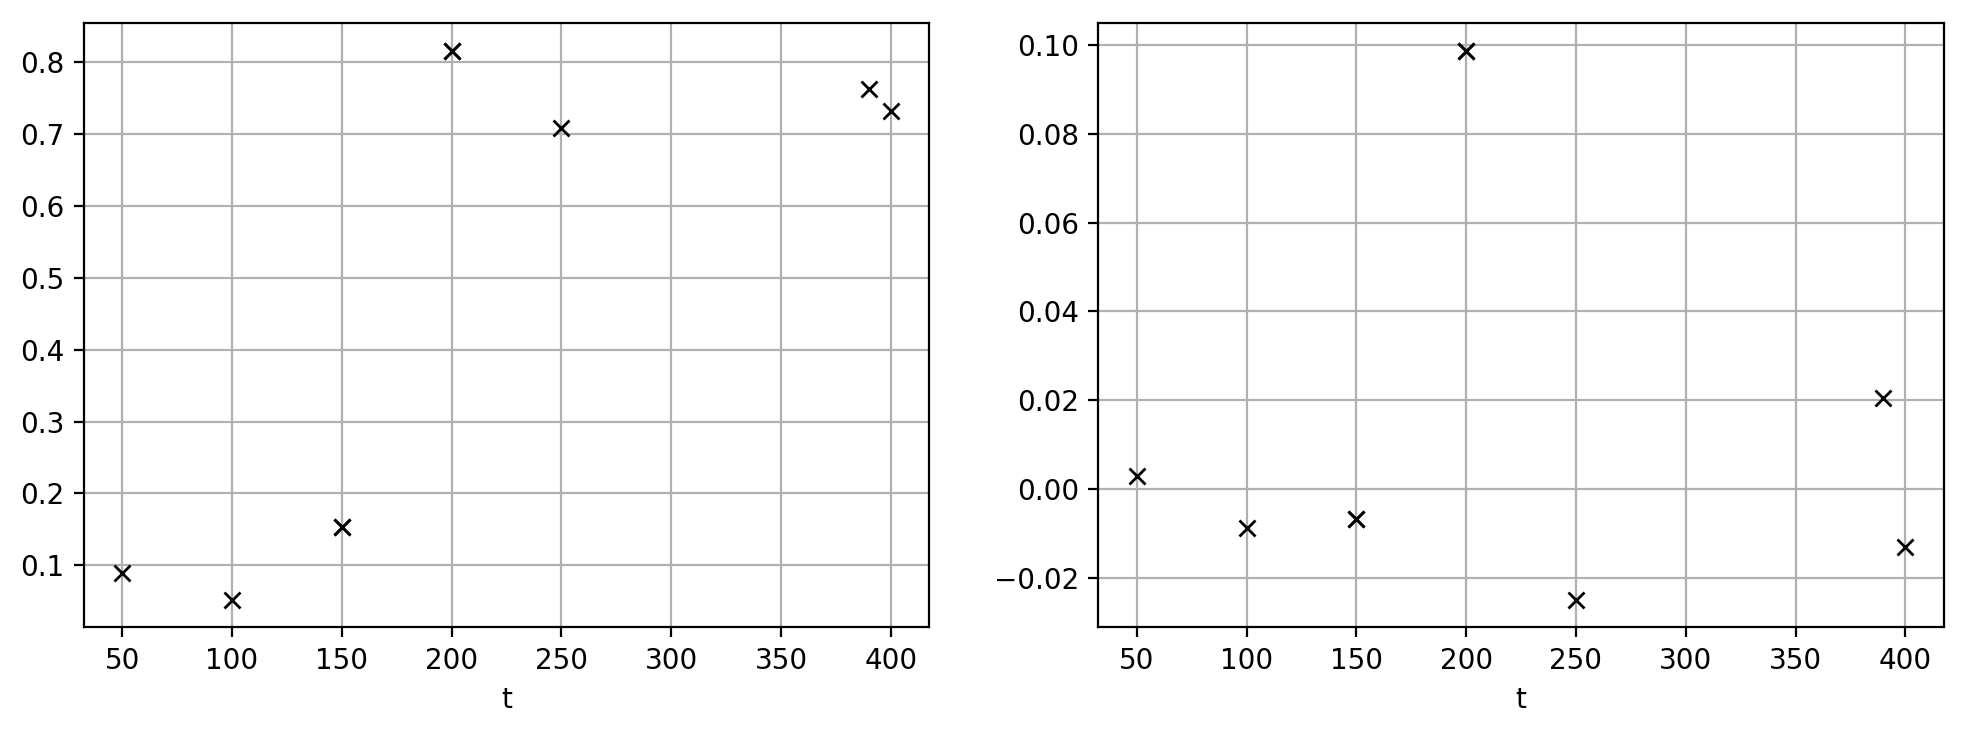

In [26]:
# Get integrated terms and ratios
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=200) 

for step in steps[1:]:
    reader.step = step
    prod = np.squeeze(reader.readData('production'));
    diss = np.squeeze(reader.readData('dissipation'));
#     diss += np.squeeze(reader.readData('dissipation_num'));
    pdil = np.squeeze(reader.readData('fluct_p_dil'))
    ax[0].plot(reader.time, sum(diss)/sum(prod),'kx')
    ax[1].plot(reader.time, sum(pdil)/sum(prod),'kx')
    
for a in ax:
    a.grid(True)
    a.set_xlabel('t')

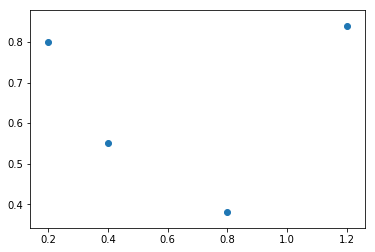

In [63]:
diss_prod = {
    0.2: 0.8, # 256x512
    0.4: 0.55, # 256x512
    0.4: 0.38, # 1024x1448
#     0.8: 0.7, # 512x724
    1.2: 0.84, #724x724
}
pdil_prod = {
    0.2: 0,
    0.4: 0,
    0.8: 0.1,
    1.2: 0.1  
}
plt.scatter(diss_prod.keys(), diss_prod.values())